# CSE185 Lab 4 Report - Code Documentation (10 pts)

* Document any commands used or additional analysis steps below!
* You should include enough detail that the instructors (or your future self) could come back to this several months from now and know exactly what you did and why you did it.
* We will not run this notebook, but will look back to see what you did especially if you end up with different answers.

In [2]:
#Ok, so I will be noting down my key steps in this notebook, I will include what command I use and why I used it

#Question 1:
'''
Question 1:
cmd = awk '$5 != 0 {print $0}' Chow_Rep1.genes.results | wc -l
I simply just change the file name for each of the six files and the resulting number
is the list of lines that do not have 0 in their TPM values
'''

#Question 2:
'''
In order to do this question I used a python script that is pasted below, the general steps include:
1) opening the chow or hfd rep1 or rep2 file and iterating through the fourth column that contains
TPM values, doing log10 of those and adding them to a list
2) Plotting those two lists into a scatter plot
'''

#Question 3:
'''
The code for this problem is also listed below and is completely run in R. Specifically, my code holds a threhold
of 8 counts in the preliminary filtering. Specific comments about the code is included in the code itself, however, two files are created
one with the deseq2 output and the second with the filtered significant genes. 
'''

#Quesion 4:
'''
This code in R is also included below with summary remarks before every command. It is important to know that a merging step
was implemented to add names of the genes to their ensembl id
'''

#Question 5:
'''
In my code for question 5 I had already created a file called significant genes to only have those with
values of padj that are less than or equal to 0.05. In this one I again merge the names file and then sort for log2fold change
'''

#the last cell in this file was used to create an upregulated and downregulated files from the significant genes list based
#on their log2foldChange values

'\nIn my code for question 5 I had already created a file called significant genes to only have those with\nvalues of padj that are less than or equal to 0.05. In this one I again merge the names file and then sort for log2fold change\n'

Populating the interactive namespace from numpy and matplotlib


<function matplotlib.pyplot.show(close=None, block=None)>

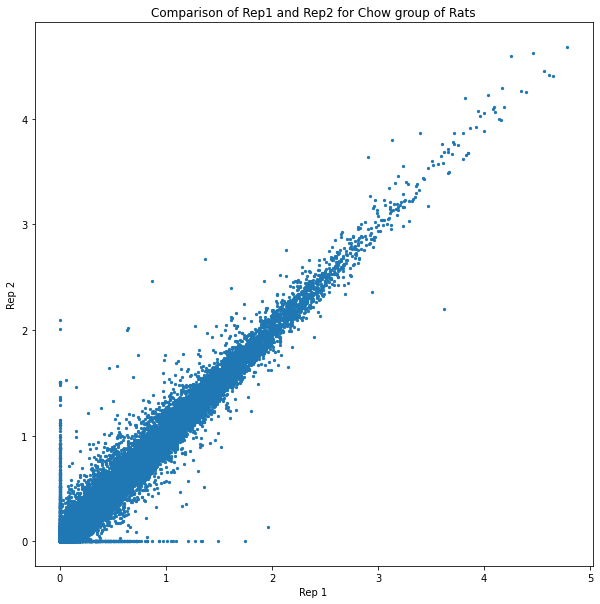

In [3]:
#QUESTION 2 CODE (part a: generating chow scatter plot):

%pylab inline
import math

chow1 = []
with open('Chow_Rep1.genes.results', 'r') as file:
    count=0
    for line in file:
        gene_id, transcript_id, length, effective_length, expected_count, tpm, fpkm = line.strip().split("\t")
        if count!=0:
            num = float(tpm)+1
            chow1.append((math.log10(num)))
        count+=1
chow2 = []
with open('Chow_Rep2.genes.results', 'r') as file:
    count=0
    for line in file:
        gene_id, transcript_id, length, effective_length, expected_count, tpm, fpkm = line.strip().split("\t")
        if count!=0:
            num = float(tpm)+1
            chow2.append((math.log10(num)))
        count+=1
plt.figure(figsize=(10,10))
x = chow1
y = chow2
plt.scatter(x, y, s=5)
plt.xlabel('Rep 1')
plt.ylabel('Rep 2')
plt.title('Comparison of Rep1 and Rep2 for Chow group of Rats')

plt.show


Populating the interactive namespace from numpy and matplotlib


<function matplotlib.pyplot.show(close=None, block=None)>

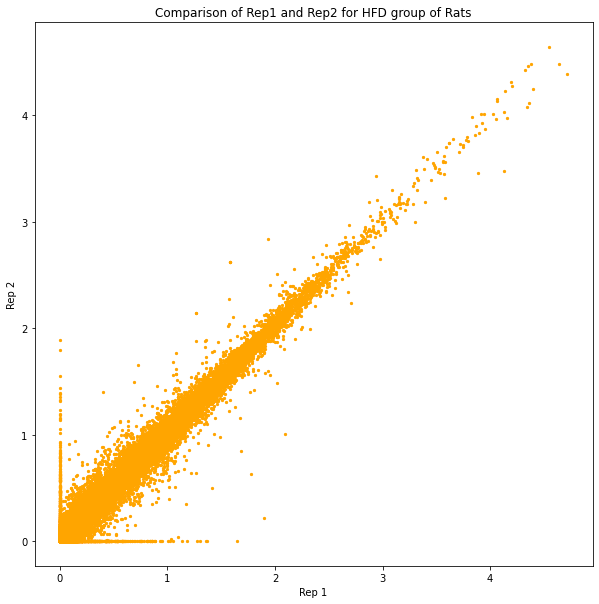

In [4]:
#QUESTION 2 CODE (part b: generating hfd scatter plot):
%pylab inline
import math


hfd1 = []
with open('HFD_Rep1.genes.results', 'r') as file:
    count=0
    for line in file:
        gene_id, transcript_id, length, effective_length, expected_count, tpm, fpkm = line.strip().split("\t")
        if count!=0:
            num = float(tpm)+1
            hfd1.append((math.log10(num)))
        count+=1
hfd2 = []
with open('HFD_Rep2.genes.results', 'r') as file:
    count=0
    for line in file:
        gene_id, transcript_id, length, effective_length, expected_count, tpm, fpkm = line.strip().split("\t")
        if count!=0:
            num = float(tpm)+1
            hfd2.append((math.log10(num)))
        count+=1
            
plt.figure(figsize=(10,10))
x = hfd1
y = hfd2
plt.scatter(x, y, s=5, color='orange')
plt.xlabel('Rep 1')
plt.ylabel('Rep 2')
plt.title('Comparison of Rep1 and Rep2 for HFD group of Rats')

plt.show


In [5]:
#Question 3: Running Differential Expression Analysis
# Run this to allow using the %%R cell magic
%load_ext rpy2.ipython

# Suppress warnings (most notable from rpy2)
import warnings
warnings.filterwarnings('ignore')

In [6]:
%%R
#Question 3 CONTINUED

##### Load the libraries we need #####
library("DESeq2")
library("tximport")
files <- c("Chow_Rep1.genes.results",
         "Chow_Rep2.genes.results",
         "Chow_Rep3.genes.results",
         "HFD_Rep1.genes.results",
         "HFD_Rep2.genes.results",
         "HFD_Rep3.genes.results")
conditions <- c(rep("Chow", 3), rep("HFD", 3))
samples <- data.frame(run = c("Chow_Rep1", "Chow_Rep2", "Chow_Rep3", "HFD_Rep1", "HFD_Rep2", "HFD_Rep3"),condition = conditions,stringsAsFactors = FALSE)

names(files) <- samples$run
txi <- tximport(files, type="rsem")

# add a pseudocount
txi$length[txi$length == 0] <- 1

#create dds object
ddsTxi <- DESeqDataSetFromTximport(txi,
                                   colData = samples,
                                   design = ~ condition)
ddsTxi <- ddsTxi[rowSums(counts(ddsTxi)) >= 8]
dds <- DESeq(ddsTxi)
num_rows <- nrow(dds)
print(num_rows)
res = results(dds)
# I want a file outputed with all the lines and then another one with just the signifcant genes
write.csv(as.data.frame(res), file = "chow_vs_hfd_deseq2.csv", row.names = TRUE)

res_clean <- res[!is.na(res$padj), ]

# Check if 'padj' column exists in the res object
if ("padj" %in% colnames(res_clean)) {
  # check for NA values in the padj column
  if (any(is.na(res_clean$padj))) {
    # this counts the number of NA values in the padj column
    cat("Number of NA values in 'padj' column:", sum(is.na(res_clean$padj)), "\n")
  } else {
    # here we filter out the significant genes
    sig_genes <- res_clean[res_clean$padj < 0.05, ]
    
    # write significant genes to a separate file
    write.csv(as.data.frame(sig_genes), file = "significant_genes.csv", row.names = TRUE)
  }
} else {
  cat("The 'padj' column does not exist in the 'res' object.\n")
}


print("DONE")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to console]: The following objects are masked from ‘package:base’:

    expand.grid, I, unname


R[write to console]: Loading r

[1] 15868
[1] "DONE"


                       X   baseMean log2FoldChange     lfcSE       stat
6252  ENSMUSG00000030483   137.7604      -5.083903 0.3789465 -13.415885
3691  ENSMUSG00000024665  6178.4308       1.545783 0.1255518  12.311912
431   ENSMUSG00000003053 19889.2993      -1.835254 0.1503862 -12.203610
11753 ENSMUSG00000055730  2586.1848      -1.600664 0.1322906 -12.099598
12205 ENSMUSG00000059824   318.0605       2.637499 0.2345897  11.243028
12009 ENSMUSG00000057933   232.5166      -2.836965 0.2585649 -10.971966
12025 ENSMUSG00000058135 13347.6371      -1.360462 0.1245956 -10.919020
2257  ENSMUSG00000020865  2337.6695      -1.457775 0.1432616 -10.175616
12885 ENSMUSG00000067225  3261.4547      -1.732680 0.1835609  -9.439262
6966  ENSMUSG00000032080  1673.3168       2.544927 0.2730559   9.320171
            pvalue         padj gene_name
6252  4.880698e-41 7.291275e-37   Cyp2b10
3691  7.814927e-35 5.837360e-31     Fads2
431   2.973440e-34 1.480674e-30   Cyp2c29
11753 1.061292e-33 3.963661e-30     Ces2

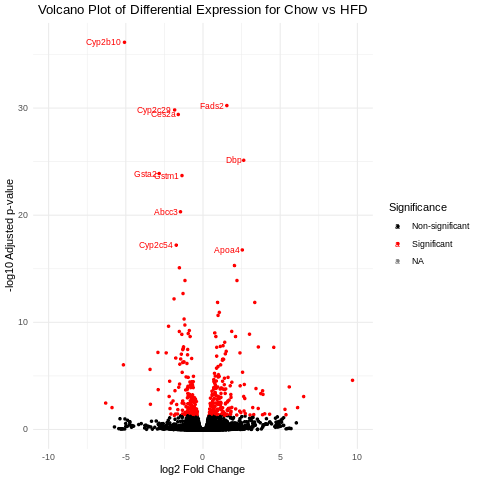

In [9]:
%%R
#QUESTION 4 CODE:
# Load Required Libraries
library(ggplot2)

# reading the data
genes <- read.csv("chow_vs_hfd_deseq2.csv")
# reading the mapping file
gene_names <- read.delim("~/public/lab4/GRCm38.75.gene_names", header = FALSE, stringsAsFactors = FALSE)
colnames(gene_names) <- c("ensembl_id", "gene_name")

# merge genes dataframe with gene_names based on the ENSEMBL gene IDs
merged <- merge(genes, gene_names, by.x = 1, by.y = 'ensembl_id', all.x = TRUE)

#creating the volcano plot
volcano_plot <- ggplot(merged, aes(x = log2FoldChange, y = -log10(padj), color = padj < 0.05)) +
  geom_point(size=1) +
  scale_color_manual(values = c("black", "red"), labels = c("Non-significant", "Significant")) +
  theme_minimal() +
  labs(x = "log2 Fold Change", y = "-log10 Adjusted p-value", color = "Significance") +ggtitle("Volcano Plot of Differential Expression for Chow vs HFD") +
  theme(plot.title = element_text(hjust = 0.5)) +
  xlim(-10, 10)

top_genes <- merged[order(merged$padj), ][1:10,]#here we choose the top genes, how many we want to annotate
volcano_plot <- volcano_plot +
  geom_text(data = top_genes, aes(label = gene_name), size=3, vjust = 0.5, hjust = 1.1)
print(top_genes)
# just showing the plot

print(volcano_plot)
ggsave("volcano_plot.png", plot = volcano_plot, width = 10, height = 8, units = "in", dpi = 300)

In [12]:
%%R
# QUESTION 5:
#Create a new column with log10 of padj
#read the file
sig <- read.csv("significant_genes.csv")

#do log 10 of that column and add that to a new column
sig$log10_padj <- -log10(sig$padj)

#filter out the significant genes
significant_genes <- sig[order(abs(sig$log10_padj), decreasing = TRUE), ]

#load the gene names file
gene_names <- read.delim("~/public/lab4/GRCm38.75.gene_names", header = FALSE, stringsAsFactors = FALSE)
colnames(gene_names) <- c("ensembl_id", "gene_name")

#merge the two
merged <- merge(significant_genes, gene_names, by.x = 1, by.y = 'ensembl_id', all.x = TRUE)
merged <- merged[order(abs(sig$log10_padj), decreasing = TRUE), ]

#print the top merged
top10 <- merged[1:10, ]
#print(top10)
print(top10[, c("X", "gene_name", "padj", "pvalue", "log2FoldChange")])
print(top10[, "X"])




                     X gene_name         padj       pvalue log2FoldChange
159 ENSMUSG00000030483   Cyp2b10 7.291275e-37 4.880698e-41      -5.083903
96  ENSMUSG00000024665     Fads2 5.837360e-31 7.814927e-35       1.545783
10  ENSMUSG00000003053   Cyp2c29 1.480674e-30 2.973440e-34      -1.835254
281 ENSMUSG00000055730     Ces2a 3.963661e-30 1.061292e-33      -1.600664
301 ENSMUSG00000059824       Dbp 7.488471e-26 2.506349e-29       2.637499
294 ENSMUSG00000057933     Gsta2 1.297864e-24 5.212655e-28      -2.836965
295 ENSMUSG00000058135     Gstm1 1.995408e-24 9.349928e-28      -1.360462
58  ENSMUSG00000020865     Abcc3 4.757728e-21 2.547816e-24      -1.457775
324 ENSMUSG00000067225   Cyp2c54 6.231439e-18 3.754130e-21      -1.732680
172 ENSMUSG00000032080     Apoa4 1.735208e-17 1.161529e-20       2.544927
 [1] "ENSMUSG00000030483" "ENSMUSG00000024665" "ENSMUSG00000003053"
 [4] "ENSMUSG00000055730" "ENSMUSG00000059824" "ENSMUSG00000057933"
 [7] "ENSMUSG00000058135" "ENSMUSG00000020865" "EN

In [10]:
%%R
#this is for creating two different files with upregulated and downregulated genes

# Read the significant genes file
significant_genes <- read.csv("significant_genes.csv")

# Separate up-regulated and down-regulated genes
upregulated_genes <- significant_genes[significant_genes$log2FoldChange > 0, ]
downregulated_genes <- significant_genes[significant_genes$log2FoldChange < 0, ]

# Write the separated genes to separate files
write.csv(upregulated_genes, file = "upreg.csv", row.names = FALSE)
write.csv(downregulated_genes, file = "downreg.csv", row.names = FALSE)

# Read the separated files
upreg <- read.csv("upreg.csv")
downreg <- read.csv("downreg.csv")

# Count the number of rows in each file
num_upreg_rows <- nrow(upreg)
num_downreg_rows <- nrow(downreg)

# Print the number of rows in each file
print(paste("Number of rows in upreg.csv:", num_upreg_rows))
print(paste("Number of rows in downreg.csv:", num_downreg_rows))

UsageError: Cell magic `%%R` not found.


For grading purposes only - Do not copy or edit this cell!